[View in Colaboratory](https://colab.research.google.com/github/Santosh-Gupta/Book2Vec/blob/master/Book2VecAnalyzeEmbeddings.ipynb)

In [0]:
import re
from collections import Counter
import time

%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import pandas as pd
import os
import random
import tensorflow as tf
from matplotlib import pyplot
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

from urllib.request import urlretrieve
from os.path import isfile, isdir
import zipfile
import keras

!pip install -U -q PyDrive
!pip install adjustText

from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import sys
from adjustText import adjust_text

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:


zip_id = input("Enter Gdrive file ID for tensorflow models: ") 

if not os.path.exists('MODEL'):
    os.makedirs('MODEL')

# DOWNLOAD ZIP
print ("Downloading zip file")
myzip = drive.CreateFile({'id': zip_id})
myzip.GetContentFile('model.zip')

# UNZIP ZIP
print ("Uncompressing zip file")
zip_ref = zipfile.ZipFile('model.zip', 'r')
zip_ref.extractall('MODEL/')
zip_ref.close()

print( os.getcwd() )
print( os.listdir('./MODEL') )

Enter Gdrive file ID for tensorflow models: 1P4jrL_cNMkT798WgOt8y7ovmwAcxbetc
Uncompressing zip file
/content
['bookVec.ckpt.data-00000-of-00001', 'bookVec.ckpt.index', 'bookVec.ckpt.meta', 'checkpoint']


In [0]:
dl_id = input("Enter Gdrive file ID for books: ") 

# DOWNLOAD ZIP
print ("Downloading  file")
myzip = drive.CreateFile({'id': dl_id})
myzip.GetContentFile('books.csv')

b = pd.read_csv( 'books.csv' )
b.head(30)
bookDictionary = b.set_index('book_id').to_dict()['title']
bookDictionary[5]
AuthorDictionary = b.set_index('book_id').to_dict()['authors']

Enter Gdrive file ID for books: 1w3uSNtc1srNaWoRHwbUE9o3baokloh9U


In [0]:
with tf.Session() as sess:
  saver = tf.train.import_meta_graph('./MODEL/bookVec.ckpt.meta')
  saver.restore(sess, './MODEL/bookVec.ckpt' )

  embeddings = tf.get_default_graph().get_tensor_by_name('embeddings:0') #Getting regular embeddings
  softmax_weights = tf.get_default_graph().get_tensor_by_name('softmax_weights:0') #Get softmax embeddings
  
  normSM = tf.sqrt(tf.reduce_sum(tf.square(softmax_weights), 1, keepdims=True))
  normalized_embeddingsSM = softmax_weights / normSM
  
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
  normalized_embeddings = embeddings / norm
  
  final_embeddings = normalized_embeddings.eval()
  final_embeddingsSM = normalized_embeddingsSM.eval()

INFO:tensorflow:Restoring parameters from ./MODEL/bookVec.ckpt


In [0]:
JaneA = np.take(final_embeddings, 29, axis=0) 
similarityJaneA = np.matmul(JaneA, np.transpose(final_embeddingsSM))

nearestJaneA = (-similarityJaneA).argsort()[0:20]

for k in range(0, 20):
  print(bookDictionary[nearestJaneA[k]], AuthorDictionary[nearestJaneA[k]])


Hamlet: Screenplay, Introduction And Film Diary Kenneth Branagh, William Shakespeare
Othello William Shakespeare
King Lear William Shakespeare
Much Ado About Nothing William Shakespeare, Barbara A. Mowat, Paul Werstine, Gail Kern Paster, Robert          Jackson
A Midsummer Night's Dream William Shakespeare, Barbara A. Mowat, Paul Werstine, Catherine Belsey
Macbeth William Shakespeare
The Tempest William Shakespeare
The Taming of the Shrew William Shakespeare
Twelfth Night William Shakespeare
The Merchant of Venice William Shakespeare, Robert          Jackson, Barbara A. Mowat, Paul Werstine
Oedipus Rex  (The Theban Plays, #1) Sophocles, J.E. Thomas
Hamlet William Shakespeare, Richard Andrews, Rex Gibson
The Odyssey Homer, Robert Fagles, E.V. Rieu, Frédéric Mugler, Bernard Knox
Julius Caesar William Shakespeare, Roma Gill
The Canterbury Tales Geoffrey Chaucer, Nevill Coghill
A Streetcar Named Desire Tennessee Williams
As You Like It William Shakespeare
The Tell-Tale Heart and Other Writ

In [0]:
#Use this code to get the book_id for any book using the title, or a word in the title. 
#The search is case sensitive. All words in a title tend to be capitalized. 

authorPhrase = 'Tolle'
lines = []
for i in AuthorDictionary:
  if type(AuthorDictionary[i]) is str:
    if authorPhrase in AuthorDictionary[i] :
        lines.append(i)
print(lines)
for j in lines:
  print(bookDictionary[j], AuthorDictionary[j]  )

[719, 744, 2694]
A New Earth: Awakening to Your Life's Purpose Eckhart Tolle
The Power of Now: A Guide to Spiritual Enlightenment Eckhart Tolle
Practicing the Power of Now: Essential Teachings, Meditations, and Exercises from the Power of Now Eckhart Tolle


In [0]:
#Use this code to get the book_id for any book using the name of the Author, or just that Author's first of last name. 
#The search is case sensitive, use capitol letters for first letter of any names. 

searchPhrase = 'Franklin'
lines = []
for i in bookDictionary:
  if type(bookDictionary[i]) is str:
    if searchPhrase in bookDictionary[i] :
        lines.append(i)
print(lines)
for j in lines:
  print(bookDictionary[j], AuthorDictionary[j]  )
  
#Coraline Neil Gaiman 282
#The Graveyard Book Neil Gaiman, Dave McKean 312
#Jane Eyre Charlotte Brontë, Michael Mason 43
#Pride and Prejudice Jane Austen 10
#A Tale of Two Cities Charles Dickens, Richard Maxwell, Hablot Knight Browne 83
#The Maze Runner (Maze Runner, #1) James Dashner 91
#Divergent  12
#great expectations 91
#Interview with the Vampire 205
#Twilight 3
#The Fault in Our Stars John Green 6
#The Perks of Being a Wallflower 68
#Dracula 97
#Romeo and Juliet William Shakespeare, Robert  29
#Hamlet 125
#The Odyssey Homer 79
#The Lightning Thief #41
#Lord of the rings 19
#The Cat in the Hat  251
#Eragon 53
#Vampire Academy 210
#Harry Potter 2
#The Gunslinger (The Dark Tower, #1) 232
#The Shining (The Shining #1) Stephen King 72
#Lonesome Dove (its a western) 757
#The Stand Stephen King 168
#11/22/63 Stephen King 295
#Charlie and the Chocolate Factory 158
#Tony Robbings 2548
#The Hobbit: Graphic Novel 466
#Twilight: The Graphic Novel 3075
#A Game of Thrones 39
#Coraline (Illustrated/Graphic Novel Edition) 7422
#Vampire Academy The Graphic Novel 7922
#A Wrinkle in Time The Graphic Novel 8383
#The Lightning Thief The Graphic Novel  9093
#A Game of Thrones: The Graphic Novel, Vol. 1 Daniel Abraham, George R.R. Martin, Tommy Patterson 3282
#The Hobbit J.R.R. Tolkien 7
#Uglies 
#Nick & Norah's Infinite Playlist 
#Princess Academy
#Hitchhickers guide to galazy 54
#The Martian Andy Weir 141
#Enders Game 70
#The Omnivore's Dilemma
#Holes 77
#American Gods (American Gods, #1) Neil Gaiman 167
#Good Omens: The Nice and Accurate Prophecies of Agnes Nutter, Witch Terry Pratchett, Neil Gaiman 283
#Leviathan (Leviathan, #1) Scott Westerfeld 1745
#Uglies (Uglies, #1) Scott Westerfeld 187
#The Hunger Games (The Hunger Games, #1) Suzanne Collins 1
#The Notebook (The Notebook, #1) Nicholas Sparks 44
#Winnie-the-Pooh (Winnie-the-Pooh, #1) A.A. Milne, Ernest H. Shepard 444
#The Tao of Pooh Benjamin Hoff, Ernest H. Shepard 1168
#Zen and the Art of Motorcycle Maintenance: An Inquiry Into Values Robert M. Pirsig #546
#Steve Jobs Walter Isaacson 128
#Creativity, Inc.: 3733
#The Power of Now: A Guide to Spiritual Enlightenment Eckhart Tolle 744
#Steal Like an Artist 1141
#The Artist's Way: A Spiritual Path to Higher Creativity Julia Cameron 1401
#Eat, Pray, Love Elizabeth Gilbert 40
#John Adams David McCullough 336
#The Lincoln Lawyer (Mickey Ha 521
#1776 David McCullough 687
#The Omnivore's Dilemma 550
#Kitchen Confidential 574
#Fast Food Nation:  398
#Princess Academy 1452
#The Fellowship of the Ring 19
#Harry Potter and the Chamber of Secrets 23
#Ender's Game  70
#Dune  126
#Airman Eoin Colfer 7919
#Artemis Fowl (Artemis Fowl, #1) 223
#The Arctic Incident  #918
#Benjamin Franklin: An American Life Walter Isaacson 1333


[1333, 2680, 4971, 5336]
Benjamin Franklin: An American Life Walter Isaacson
The Autobiography of Benjamin Franklin Benjamin Franklin, Lewis Leary
No Ordinary Time: Franklin and Eleanor Roosevelt: The Home Front in World War II Doris Kearns Goodwin
The First American: The Life and Times of Benjamin Franklin H.W. Brands


In [0]:


hereGoesSM =  np.take(final_embeddings, 97, axis=0) -  np.take(final_embeddings, 205, axis=0)  #-   np.take(final_embeddings, 7, axis=0) 


#dacula vampire classic vampire 97 - interview with vampire 205  = classics 

similarityhereGoes = np.matmul(hereGoesSM, np.transpose(final_embeddingsSM))

nearesthereGoes = (-similarityhereGoes).argsort()[0:100]


for k in range(0, 100):
  print(bookDictionary[nearesthereGoes[k]], AuthorDictionary[nearesthereGoes[k]])

Little Dorrit Charles Dickens, Helen Small, Stephen Wall
A Christmas Carol, The Chimes and The Cricket on the Hearth Charles Dickens, Katharine Kroeber Wiley
The Strange Case of Dr. Jekyll and Mr. Hyde and Other Tales of Terror Robert Louis Stevenson, Robert Mighall
Our Mutual Friend Charles Dickens
The Tenant of Wildfell Hall Anne Brontë, Stevie Davies
The Picture of Dorian Gray: A Graphic Novel Ian Edginton, Oscar Wilde, I.N.J. Culbard
King Solomon's Mines (Allan Quatermain, #1) H. Rider Haggard
Eugene Onegin Alexander Pushkin, James E. Falen
The Moonstone Wilkie Collins, Carolyn G. Heilbrun
Villette Charlotte Brontë, A.S. Byatt, Μαρία Λαϊνά, Ignes Sodre
Dead Souls Nikolai Gogol, Robert A. Maguire
The Woman in White Wilkie Collins, Matthew Sweet
My Man Jeeves (Jeeves, #1) P.G. Wodehouse
Confessions Augustine of Hippo, Henry Chadwick, Albert Cook Outler
The Mill on the Floss George Eliot, A.S. Byatt
The House of Silk (Sherlock Holmes, #1) Anthony Horowitz
North and South Elizabeth Gas

In [0]:
hereGoesSM =  np.take(final_embeddings, 126, axis=0) +  np.take(final_embeddings, 23, axis=0) -   np.take(final_embeddings, 7, axis=0) 


#dune 126 + harry potter 23 - hobbit 7 = dune + enders game

similarityhereGoes = np.matmul(hereGoesSM, np.transpose(final_embeddingsSM))

nearesthereGoes = (-similarityhereGoes).argsort()[0:100]


for k in range(0, 100):
  print(bookDictionary[nearesthereGoes[k]], AuthorDictionary[nearesthereGoes[k]])

Children of Dune (Dune Chronicles #3) Frank Herbert
Dune Messiah (Dune Chronicles #2) Frank Herbert
Speaker for the Dead (Ender's Saga, #2) Orson Scott Card
Ender's Shadow (Ender's Shadow, #1) Orson Scott Card
Children of the Mind (Ender's Saga, #4) Orson Scott Card
Heretics of Dune (Dune Chronicles #5) Frank Herbert
Xenocide (Ender's Saga, #3) Orson Scott Card
Second Foundation (Foundation #3) Isaac Asimov
Chapterhouse: Dune (Dune Chronicles #6) Frank Herbert
God Emperor of Dune (Dune Chronicles #4) Frank Herbert
Shadow of the Giant (Ender's Shadow, #4) Orson Scott Card
Foundation's Edge (Foundation #4) Isaac Asimov
Foundation (Foundation #1) Isaac Asimov
Shadow of the Hegemon (Ender's Shadow, #2) Orson Scott Card
Mostly Harmless (Hitchhiker's Guide to the Galaxy, #5) Douglas Adams
Shadow Puppets (Ender's Shadow, #3) Orson Scott Card
Anthem Ayn Rand
So Long, and Thanks for All the Fish (Hitchhiker's Guide to the Galaxy, #4) Douglas Adams
The Restaurant at the End of the Universe (Hitc

In [0]:
hereGoesSM =  np.take(final_embeddings, 3075, axis=0)  - np.take(final_embeddings, 3, axis=0) + np.take(final_embeddings, 282, axis=0)# + np.take(final_embeddings, 546, axis=0) + np.take(final_embeddings, 1545, axis=0)

#twilight graphic novel 3075 - twilight 3 + coraline 282 = coraline graphic novel (top 2)

similarityhereGoes = np.matmul(hereGoesSM, np.transpose(final_embeddingsSM))

nearesthereGoes = (-similarityhereGoes).argsort()[0:15]


for k in range(0, 15):
  print(bookDictionary[nearesthereGoes[k]], AuthorDictionary[nearesthereGoes[k]])

Fortunately, the Milk Neil Gaiman, Skottie Young
Coraline (Illustrated/Graphic Novel Edition) Neil Gaiman, P. Craig Russell
Odd and the Frost Giants Neil Gaiman, Mark Buckingham
Fragile Things: Short Fictions and Wonders Neil Gaiman
The Sandman: Overture Neil Gaiman, J.H. Williams III, Dave Stewart, Todd Klein
The Sleeper and the Spindle Neil Gaiman, Chris Riddell
Death: The High Cost of Living Collected Neil Gaiman, Chris Bachalo, Mark Buckingham, Tori Amos
Trigger Warning: Short Fictions and Disturbances Neil Gaiman
Dream Country (The Sandman #3) Neil Gaiman, Kelley Jones, Charles Vess, Colleen Doran, Malcolm Jones III, Steve Erickson
Un Lun Dun China Miéville
Marvel 1602 Neil Gaiman, Andy Kubert, Richard Isanove, Peter Sanderson
Smoke and Mirrors: Short Fiction and Illusions Neil Gaiman
Neil Gaiman's Neverwhere Mike Carey, Glenn Fabry, Neil Gaiman
The Doll's House (The Sandman #2) Neil Gaiman, Steve Parkhouse, Chris Bachalo, Michael Zulli, Mike Dringenberg, Malcolm Jones III, Todd K

In [0]:
hereGoesSM =  np.take(final_embeddings, 3075, axis=0)  - np.take(final_embeddings, 3, axis=0) + np.take(final_embeddings, 282, axis=0)# + np.take(final_embeddings, 546, axis=0) + np.take(final_embeddings, 1545, axis=0)

#twilight graphic novel 3075 - twilight 3 + coraline 282 = coraline graphic novel (top 2)

similarityhereGoes = np.matmul(hereGoesSM, np.transpose(final_embeddingsSM))

nearesthereGoes = (-similarityhereGoes).argsort()[0:15]


for k in range(0, 15):
  print(bookDictionary[nearesthereGoes[k]], AuthorDictionary[nearesthereGoes[k]])

Fortunately, the Milk Neil Gaiman, Skottie Young
Coraline (Illustrated/Graphic Novel Edition) Neil Gaiman, P. Craig Russell
Odd and the Frost Giants Neil Gaiman, Mark Buckingham
Fragile Things: Short Fictions and Wonders Neil Gaiman
The Sandman: Overture Neil Gaiman, J.H. Williams III, Dave Stewart, Todd Klein
The Sleeper and the Spindle Neil Gaiman, Chris Riddell
Death: The High Cost of Living Collected Neil Gaiman, Chris Bachalo, Mark Buckingham, Tori Amos
Trigger Warning: Short Fictions and Disturbances Neil Gaiman
Dream Country (The Sandman #3) Neil Gaiman, Kelley Jones, Charles Vess, Colleen Doran, Malcolm Jones III, Steve Erickson
Un Lun Dun China Miéville
Marvel 1602 Neil Gaiman, Andy Kubert, Richard Isanove, Peter Sanderson
Smoke and Mirrors: Short Fiction and Illusions Neil Gaiman
Neil Gaiman's Neverwhere Mike Carey, Glenn Fabry, Neil Gaiman
The Doll's House (The Sandman #2) Neil Gaiman, Steve Parkhouse, Chris Bachalo, Michael Zulli, Mike Dringenberg, Malcolm Jones III, Todd K

In [0]:
hereGoesSM =  np.take(final_embeddings, 444, axis=0)  +  np.take(final_embeddings, 546, axis=0) # + np.take(final_embeddings, 546, axis=0) + np.take(final_embeddings, 1545, axis=0)

#Pride and preduce - a tale of two cities = some romance

#Pride and prejuce - tale of two cities = romance
# Coroline - American gods  = bunch of kids books
#neila gaiman kids - most popular niel gaiman = kids books A Series of Unfortunate Events, The Tail of Emily Windsnap, Molly Moon's Incredible Book of Hypnotism
#used analogies checkpiont

similarityhereGoes = np.matmul(hereGoesSM, np.transpose(final_embeddingsSM))

nearesthereGoes = (-similarityhereGoes).argsort()[0:30]


for k in range(0, 29):
  print(bookDictionary[nearesthereGoes[k]], AuthorDictionary[nearesthereGoes[k]])

The Tao of Pooh Benjamin Hoff, Ernest H. Shepard
Zen and the Art of Motorcycle Maintenance: An Inquiry Into Values Robert M. Pirsig
The House at Pooh Corner (Winnie-the-Pooh, #2) A.A. Milne, Ernest H. Shepard
The Wind in the Willows Kenneth Grahame, Gillian Avery
Jonathan Livingston Seagull Richard Bach, Russell Munson
Walden Henry David Thoreau
Winnie-the-Pooh (Winnie-the-Pooh, #1) A.A. Milne, Ernest H. Shepard
Tao Te Ching Lao Tzu, Gia-Fu Feng, Jane English, Chungliang Al Huang, Rowena Pattee Kryder, Toinette Lippe
The Prophet Kahlil Gibran
Siddhartha Hermann Hesse, Hilda Rosner
Illusions: The Adventures of a Reluctant Messiah Richard Bach
The Velveteen Rabbit Margery Williams Bianco, William   Nicholson
Leaves of Grass Walt Whitman
On the Road Jack Kerouac
The Tale of Peter Rabbit Beatrix Potter
The Cat in the Hat Dr. Seuss
The Lorax Dr. Seuss
The Power of Myth Joseph Campbell, Bill Moyers
Oh, The Places You'll Go! Dr. Seuss
The Elements of Style William Strunk Jr., E.B. White
How t

In [0]:
hereGoes =  np.take(final_embeddings, 10, axis=0)  -  np.take(final_embeddings, 83, axis=0) # + np.take(final_embeddings, 91, axis=0)

#Pride and preduce - a tale of two cities = some romance

#Pride and prejuce - tale of two cities = romance
# Coroline - American gods  = bunch of kids books
#neila gaiman kids - most popular niel gaiman = kids books A Series of Unfortunate Events, The Tail of Emily Windsnap, Molly Moon's Incredible Book of Hypnotism
#used analogies checkpiont

similarityhereGoes = np.matmul(hereGoes, np.transpose(final_embeddings))

nearesthereGoes = (-similarityhereGoes).argsort()[1:30]


for k in range(1, 29):
  print(bookDictionary[nearesthereGoes[k]], AuthorDictionary[nearesthereGoes[k]])

Magic Burns (Kate Daniels, #2) Ilona Andrews
Dragon Rider (Dragon Rider, #1) Cornelia Funke
Can You Keep a Secret? Sophie Kinsella
Isla and the Happily Ever After (Anna and the French Kiss, #3) Stephanie Perkins
The Diviners (The Diviners, #1) Libba Bray
Dream a Little Dream (Chicago Stars, #4) Susan Elizabeth Phillips
On Dublin Street (On Dublin Street, #1) Samantha Young
The Descendants Kaui Hart Hemmings
Undeniable (Undeniable, #1) Madeline Sheehan
Crash into You (Pushing the Limits, #3) Katie McGarry
You Had Me At Hello Mhairi McFarlane
Tempt Me at Twilight (The Hathaways, #3) Lisa Kleypas, Rosalyn Landor
This Girl (Slammed, #3) Colleen Hoover
The Virgin Suicides Jeffrey Eugenides
Briar's Book (Circle of Magic, #4) Tamora Pierce
Fire (Graceling Realm, #2) Kristin Cashore
Fangirl Rainbow Rowell
Wild Cards (Wild Cards, #1) Simone Elkeles
The Indigo Spell (Bloodlines, #3) Richelle Mead
The Midwife: A Memoir of Birth, Joy, and Hard Times Jennifer Worth
Olivia Joules and the Overactive 

In [0]:
hereGoesSM =  np.take(final_embeddings, 10, axis=0)  -  np.take(final_embeddings, 83, axis=0) # + np.take(final_embeddings, 91, axis=0)

#Pride and preduce - a tale of two cities = some romance

#Pride and prejuce - tale of two cities = romance
# Coroline - American gods  = bunch of kids books
#neila gaiman kids - most popular niel gaiman = kids books A Series of Unfortunate Events, The Tail of Emily Windsnap, Molly Moon's Incredible Book of Hypnotism
#used analogies checkpiont

similarityhereGoes = np.matmul(hereGoesSM, np.transpose(final_embeddingsSM))

nearesthereGoes = (-similarityhereGoes).argsort()[1:30]


for k in range(1, 29):
  print(bookDictionary[nearesthereGoes[k]], AuthorDictionary[nearesthereGoes[k]])

Forbidden Tabitha Suzuma
Point of Retreat (Slammed, #2) Colleen Hoover
The Unidentified Redhead (Redhead, #1) Alice Clayton
Never Too Far (Rosemary Beach, #2; Too Far, #2) Abbi Glines
The Coincidence of Callie & Kayden (The Coincidence, #1) Jessica Sorensen
Queen of Babble in the Big City (Queen of Babble, #2) Meg Cabot
Radiance (Wraith Kings, #1) Grace Draven
Romancing Mister Bridgerton (Bridgertons, #4) Julia Quinn
Queen of Babble Gets Hitched (Queen of Babble, #3) Meg Cabot
Thief (Love Me with Lies, #3) Tarryn Fisher
The Marriage Bargain (Marriage to a Billionaire, #1) Jennifer Probst
Queen of Babble (Queen of Babble, #1) Meg Cabot
Losing It (Losing It, #1) Cora Carmack
Ten Tiny Breaths (Ten Tiny Breaths, #1) K.A. Tucker
Lola and the Boy Next Door (Anna and the French Kiss, #2) Stephanie Perkins
This Girl (Slammed, #3) Colleen Hoover
The Siren (The Original Sinners, #1) Tiffany Reisz
Dirty Red (Love Me with Lies, #2) Tarryn Fisher
Second Chance Boyfriend (One Week Girlfriend, #2) Mo

In [0]:
#hereGoes = np.mean([np.take(final_embeddings, 125, axis=0),  np.take(final_embeddings,  44, axis=0)], axis=0)

#Hamlet + the Nookbook = ROMEO AND JULIET1!!!!

hereGoes =  np.take(final_embeddings, 125, axis=0)  +  np.take(final_embeddings, 10, axis=0) # + np.take(final_embeddings, 91, axis=0)
#Pride and prejuce - tale of two cities = romance
# Coroline - American gods  = bunch of kids books
#neila gaiman kids - most popular niel gaiman = kids books A Series of Unfortunate Events, The Tail of Emily Windsnap, Molly Moon's Incredible Book of Hypnotism
#used analogies checkpiont

similarityhereGoes = np.matmul(hereGoes, np.transpose(final_embeddings))

nearesthereGoes = (-similarityhereGoes).argsort()[0:30]


for k in range(0, 29):
  print(bookDictionary[nearesthereGoes[k]], AuthorDictionary[nearesthereGoes[k]])

Pride and Prejudice Jane Austen
Hamlet William Shakespeare, Richard Andrews, Rex Gibson
King Lear William Shakespeare
Romeo and Juliet William Shakespeare, Robert           Jackson
Great Expectations Charles Dickens
Othello William Shakespeare
Wuthering Heights Emily Brontë, Richard J. Dunn
A Midsummer Night's Dream William Shakespeare, Barbara A. Mowat, Paul Werstine, Catherine Belsey
Macbeth William Shakespeare
Twelfth Night William Shakespeare
The Merchant of Venice William Shakespeare, Robert          Jackson, Barbara A. Mowat, Paul Werstine
The Taming of the Shrew William Shakespeare
Much Ado About Nothing William Shakespeare, Barbara A. Mowat, Paul Werstine, Gail Kern Paster, Robert          Jackson
The Tempest William Shakespeare
Crime and Punishment Fyodor Dostoyevsky, David McDuff
Les Misérables Victor Hugo, Lee Fahnestock, Norman MacAfee
A Tale of Two Cities Charles Dickens, Richard Maxwell, Hablot Knight Browne
Emma Jane Austen, Fiona Stafford
Anna Karenina Leo Tolstoy, Loui

In [0]:
hereGoesSM =  np.take(final_embeddings, 125, axis=0)  +  np.take(final_embeddings, 44, axis=0) # + np.take(final_embeddings, 91, axis=0)
#Hamlet + the Nookbook 
#Pride and prejuce - tale of two cities = romance
# Coroline - American gods  = bunch of kids books
#neila gaiman kids - most popular niel gaiman = kids books A Series of Unfortunate Events, The Tail of Emily Windsnap, Molly Moon's Incredible Book of Hypnotism
#used analogies checkpiont

similarityhereGoes = np.matmul(hereGoesSM, np.transpose(final_embeddingsSM))

nearesthereGoes = (-similarityhereGoes).argsort()[0:30]


for k in range(0, 29):
  print(bookDictionary[nearesthereGoes[k]], AuthorDictionary[nearesthereGoes[k]])

A Midsummer Night's Dream William Shakespeare, Barbara A. Mowat, Paul Werstine, Catherine Belsey
Romeo and Juliet William Shakespeare, Robert           Jackson
Othello William Shakespeare
Macbeth William Shakespeare
The Taming of the Shrew William Shakespeare
A Walk to Remember Nicholas Sparks
Twelfth Night William Shakespeare
Much Ado About Nothing William Shakespeare, Barbara A. Mowat, Paul Werstine, Gail Kern Paster, Robert          Jackson
The Scarlet Letter Nathaniel Hawthorne, Thomas E. Connolly, Nina Baym
King Lear William Shakespeare
Julius Caesar William Shakespeare, Roma Gill
The Merchant of Venice William Shakespeare, Robert          Jackson, Barbara A. Mowat, Paul Werstine
Les Misérables Victor Hugo, Lee Fahnestock, Norman MacAfee
Hamlet: Screenplay, Introduction And Film Diary Kenneth Branagh, William Shakespeare
The Phantom of the Opera Gaston Leroux, Alexander Teixeira de Mattos
Wuthering Heights Emily Brontë, Richard J. Dunn
The Odyssey Homer, Robert Fagles, E.V. Rieu, 

In [0]:
hereGoes =  np.take(final_embeddings, 187, axis=0)  -  np.take(final_embeddings, 1745, axis=0) # + np.take(final_embeddings, 91, axis=0)
#Pride and prejuce - tale of two cities = romance
# Coroline - American gods  = bunch of kids books
#neila gaiman kids - most popular niel gaiman = kids books A Series of Unfortunate Events, The Tail of Emily Windsnap, Molly Moon's Incredible Book of Hypnotism
#used analogies checkpiont

similarityhereGoes = np.matmul(hereGoes, np.transpose(final_embeddings))

nearesthereGoes = (-similarityhereGoes).argsort()[1:30]


for k in range(1, 29):
  print(bookDictionary[nearesthereGoes[k]], AuthorDictionary[nearesthereGoes[k]])

Rubyfruit Jungle Rita Mae Brown
Pretties (Uglies, #2) Scott Westerfeld
Fruits Basket, Vol. 4 Natsuki Takaya, Alethea Nibley, Athena Nibley
White Oleander Janet Fitch
Masquerade (Blue Bloods, #2) Melissa de la Cruz
Smashed: Story of a Drunken Girlhood Koren Zailckas
At Grave's End (Night Huntress, #3) Jeaniene Frost
Vanishing Girls Lauren Oliver
Three Wishes Liane Moriarty
Such a Pretty Girl Laura Wiess
Stargirl (Stargirl, #1) Jerry Spinelli
Plain Truth Jodi Picoult
The Good Girl Mary Kubica
Princess Mia (The Princess Diaries, #9) Meg Cabot
A Dark Lure Loreth Anne White
Extras (Uglies, #4) Scott Westerfeld
Matched (Matched, #1) Ally Condie
Commencement  J. Courtney Sullivan
A Light in the Attic Shel Silverstein
The Unbecoming of Mara Dyer (Mara Dyer, #1) Michelle Hodkin
Finding Cinderella (Hopeless, #2.5) Colleen Hoover
Reached (Matched, #3) Ally Condie
A Child Called "It" (Dave Pelzer #1) Dave Pelzer
Entwined with You (Crossfire, #3) Sylvia Day
Blue Bloods (Blue Bloods, #1) Melissa de 

In [0]:
hereGoesSM =  np.take(final_embeddings, 187, axis=0)  -  np.take(final_embeddings, 1745, axis=0) # + np.take(final_embeddings, 91, axis=0)
#uglies 187 - leviation 1745
#Pride and prejuce - tale of two cities = romance
# Coroline - American gods  = bunch of kids books
#neila gaiman kids - most popular niel gaiman = kids books A Series of Unfortunate Events, The Tail of Emily Windsnap, Molly Moon's Incredible Book of Hypnotism
#used analogies checkpiont

similarityhereGoes = np.matmul(hereGoesSM, np.transpose(final_embeddingsSM))

nearesthereGoes = (-similarityhereGoes).argsort()[0:30]


for k in range(0, 29):
  print(bookDictionary[nearesthereGoes[k]], AuthorDictionary[nearesthereGoes[k]])

Pretties (Uglies, #2) Scott Westerfeld
Specials (Uglies, #3) Scott Westerfeld
Crank (Crank, #1) Ellen Hopkins
Extras (Uglies, #4) Scott Westerfeld
Glass (Crank, #2) Ellen Hopkins
Vanishing Acts Jodi Picoult
The Pact Jodi Picoult
Something Blue (Darcy & Rachel, #2) Emily Giffin
Burned (Burned, #1) Ellen Hopkins
True Believer (Jeremy Marsh & Lexie Darnell, #1) Nicholas Sparks
At First Sight (Jeremy Marsh & Lexie Darnell, #2) Nicholas Sparks
Someone Like You Sarah Dessen
Betrayed (House of Night, #2) P.C. Cast, Kristin Cast
The Death and Life of Charlie St. Cloud Ben Sherwood
Dreamland Sarah Dessen
Impulse (Impulse, #1) Ellen Hopkins
Cut Patricia McCormick
Identical Ellen Hopkins
Gossip Girl (Gossip Girl, #1) Cecily von Ziegesar
Prozac Nation Elizabeth Wurtzel
Handle with Care Jodi Picoult
Shopaholic & Baby (Shopaholic, #5) Sophie Kinsella
Killer (Pretty Little Liars, #6) Sara Shepard
Forever in Blue: The Fourth Summer of the Sisterhood (Sisterhood, #4) Ann Brashares
The Tenth Circle Jodi

In [0]:
hereGoes =  np.take(final_embeddings, 282, axis=0)  -  np.take(final_embeddings, 167, axis=0) #+ np.take(final_embeddings, 3, axis=0)
# Coroline - American gods  = bunch of kids books
#neila gaiman kids - most popular niel gaiman = kids books Wonder , Tales from a Not-So-Fabulous Life, The Tiger
#used analogies checkpiont

similarityhereGoes = np.matmul(hereGoes, np.transpose(final_embeddings))

nearesthereGoes = (-similarityhereGoes).argsort()[1:30]


for k in range(1, 29):
  print(bookDictionary[nearesthereGoes[k]], AuthorDictionary[nearesthereGoes[k]])

Beastly (Beastly, #1; Kendra Chronicles, #1) Alex Flinn
Rapunzel Paul O. Zelinsky
Tuck Everlasting Natalie Babbitt
Flipped Wendelin Van Draanen
Something Like Fate Susane Colasanti
Eclipse: The Complete Illustrated Movie Companion (The Twilight Saga: The Official Illustrated Movie Companion, #3) Mark Cotta Vaz
Shiver (The Wolves of Mercy Falls, #1) Maggie Stiefvater
Because of Winn-Dixie Kate DiCamillo, Chris Sheban
The Tale of Despereaux Kate DiCamillo, Timothy Basil Ering
Suzanne's Diary for Nicholas James Patterson
Cross My Heart and Hope to Spy (Gallagher Girls, #2) Ally Carter
Peter and the Shadow Thieves (Peter and the Starcatchers, #2) Dave Barry, Ridley Pearson, Greg Call
The Story of Tracy Beaker Jacqueline Wilson, Nick Sharratt
Matilda Roald Dahl, Quentin Blake
The House of the Seven Gables Nathaniel Hawthorne, Robert S. Levine
Only the Good Spy Young (Gallagher Girls, #4) Ally Carter
The Ripper (The Vampire Diaries: Stefan's Diaries, #4) L.J. Smith, Kevin Williamson, Julie P

In [0]:
hereGoesSM =  np.take(final_embeddings, 282, axis=0)  -  np.take(final_embeddings, 167, axis=0) #+ np.take(final_embeddings, 3, axis=0)
# Coroline - American gods  = bunch of kids books
#neila gaiman kids - most popular niel gaiman = kids books Wonder , Tales from a Not-So-Fabulous Life, The Tiger
#used analogies checkpiont

similarityhereGoes = np.matmul(hereGoesSM, np.transpose(final_embeddingsSM))

nearesthereGoes = (-similarityhereGoes).argsort()[0:30]


for k in range(0, 29):
  print(bookDictionary[nearesthereGoes[k]], AuthorDictionary[nearesthereGoes[k]])

The Lion King: A little Golden Book Justine Korman Fontes, Don Williams, Walt Disney Company
The Little Mermaid Michael Teitelbaum, Sue DiCicco
So B. It Sarah Weeks
Let's Pretend This Never Happened (Dear Dumb Diary #1) Jim Benton
Cinderella Loek Koopmans, Charles Perrault, Anthea Bell
11 Birthdays (Willow Falls, #1) Wendy Mass
Wanted (Pretty Little Liars, #8) Sara Shepard
Beauty and the Beast (Disney) Teddy Slater, Ron Dias, Ric González
The Three Little Pigs (Disney Classic) Al Dempster, Milt Banta, Golden Books, Walt Disney Company
Hafalan Shalat Delisa Tere Liye
Sleeping Beauty: a Little Golden Book (Disney Princess) Michael Teitelbaum, Walt Disney Company
Red Riding Hood Sarah Blakley-Cartwright, David Leslie Johnson, Catherine Hardwicke
Schooled Gordon Korman
Rules Cynthia Lord
Don't Judge a Girl by Her Cover (Gallagher Girls, #3) Ally Carter
Chicken Soup for the Teenage Soul: 101 Stories of Life, Love and Learning (Chicken Soup for the Soul) Jack Canfield, Mark Victor Hansen, Ki

In [0]:
hereGoes =  np.take(final_embeddings, 29, axis=0) -  np.take(final_embeddings, 125, axis=0) #+ np.take(final_embeddings, 68, axis=0)
# Romeo and Juliet William Shakespeare - Hamlet  = Lover Unleashed, Eat, Pray, Love , Rock with Me , Marley and Me
#shakesphere romance - shakespwhere = romance

similarityhereGoes = np.matmul(hereGoes, np.transpose(final_embeddings))

nearesthereGoes = (-similarityhereGoes).argsort()[1:30]


for k in range(1, 29):
  print(bookDictionary[nearesthereGoes[k]], AuthorDictionary[nearesthereGoes[k]])

Bridget Jones's Diary (Bridget Jones, #1) Helen Fielding
The Time Traveler's Wife Audrey Niffenegger
Under the Tuscan Sun Frances Mayes
The Girls' Guide to Hunting and Fishing Melissa Bank
Fifty Shades of Grey (Fifty Shades, #1) E.L. James
The Nanny Diaries (Nanny, #1) Emma McLaughlin, Nicola Kraus
Breaking Dawn (Twilight, #4) Stephenie Meyer
Crow's Row (Crow's Row, #1) Julie Hockley
True Love Story Willow Aster
The Color of Secrets Lindsay Ashford
The Witness Sandra Brown
The Hunger Games: Official Illustrated Movie Companion Kate Egan
The Wedding Girl Madeleine Wickham
The Law of Attraction: The Basics of the Teachings of Abraham Esther Hicks, Jerry Hicks
Twice Tempted (Night Prince, #2) Jeaniene Frost
Divine Secrets of the Ya-Ya Sisterhood Rebecca Wells
The Other Boleyn Girl (The Plantagenet and Tudor Novels, #9) Philippa Gregory
Vain (The Seven Deadly, #1) Fisher Amelie
Maid for Love (Gansett Island Series, #1) Marie Force
The Lovely Bones Alice Sebold
Memoirs of a Geisha Arthur Go

In [0]:
hereGoesSM =  np.take(final_embeddings, 29, axis=0) -  np.take(final_embeddings, 125, axis=0) #+ np.take(final_embeddings, 68, axis=0)
# Romeo and Juliet William Shakespeare - Hamlet  = Lover Unleashed, Eat, Pray, Love , Rock with Me , Marley and Me
#shakesphere romance - shakespwhere = romance

similarityhereGoes = np.matmul(hereGoesSM, np.transpose(final_embeddingsSM))

nearesthereGoes = (-similarityhereGoes).argsort()[0:30]


for k in range(0, 29):
  print(bookDictionary[nearesthereGoes[k]], AuthorDictionary[nearesthereGoes[k]])

Mr. Maybe Jane Green
New Moon: The Complete Illustrated Movie Companion (The Twilight Saga: The Official Illustrated Movie Companion, #2) Mark Cotta Vaz
Vampire Academy Box Set (Vampire Academy, #1-4) Richelle Mead
The Gatecrasher Madeleine Wickham
Effortless (Thoughtless, #2) S.C. Stephens
Jemima J Jane Green
Dream Man Linda Howard
Love Unrehearsed (Love, #2) Tina Reber
The Rose Garden Susanna Kearsley
Thoughtless (Thoughtless, #1) S.C. Stephens
The Twilight Saga Breaking Dawn Part 1: The Official Illustrated Movie Companion (The Twilight Saga: The Official Illustrated Movie Companion, #4) Mark Cotta Vaz
Vampire Academy: The Ultimate Guide (Vampire Academy) Michelle Rowen, Richelle Mead
The Hunger Games Tribute Guide Emily Seife
No Rest for the Wicked (Immortals After Dark #3) Kresley Cole
Fireproof Eric Wilson
Bad Rep (Bad Rep, #1) A. Meredith Walters
Tough Customer (Mitchell & Associates #2) Sandra Brown
Forget You Jennifer Echols
The Hunger Games: Official Illustrated Movie Compani

In [0]:
hereGoes =  np.take(final_embeddings, 3, axis=0) -  np.take(final_embeddings, 205, axis=0) #+ np.take(final_embeddings, 68, axis=0)
# Twilight - InterView with Vampire  = The Notebook A ROMANCE
# vampire romance -  vampire = romance

similarityhereGoes = np.matmul(hereGoes, np.transpose(final_embeddings))

nearesthereGoes = (-similarityhereGoes).argsort()[1:30]


for k in range(1, 29):
  print(bookDictionary[nearesthereGoes[k]], AuthorDictionary[nearesthereGoes[k]])

Twilight: The Complete Illustrated Movie Companion Mark Cotta Vaz
Dear John Nicholas Sparks
The Longest Ride Nicholas Sparks
Safe Haven Nicholas Sparks
The Truth About Forever Sarah Dessen
The Host (The Host, #1) Stephenie Meyer
The Sisterhood of the Traveling Pants (Sisterhood, #1) Ann Brashares
New Moon (Twilight, #2) Stephenie Meyer
The Guernsey Literary and Potato Peel Pie Society Mary Ann Shaffer, Annie Barrows
Fifty Shades Freed (Fifty Shades, #3) E.L. James
The Last Song Nicholas Sparks
Little Women (Little Women, #1) Louisa May Alcott
If I Stay (If I Stay, #1) Gayle Forman
Three Cups of Tea: One Man's Mission to Promote Peace ... One School at a Time Greg Mortenson, David Oliver Relin
Pride and Prejudice Jane Austen
The Summer I Turned Pretty (Summer, #1) Jenny Han
A Thousand Splendid Suns Khaled Hosseini
Plain Truth Jodi Picoult
The Lucky One Nicholas Sparks
All Fall Down Jennifer Weiner
The Choice Nicholas Sparks
Fifty Shades of Grey (Fifty Shades, #1) E.L. James
Scoring Wild

In [0]:
hereGoesSM =  np.take(final_embeddings, 3, axis=0) -  np.take(final_embeddings, 205, axis=0) #+ np.take(final_embeddings, 68, axis=0)
# Twilight - InterView with Vampire  = The Notebook A ROMANCE
# vampire romance -  vampire = romance

similarityhereGoes = np.matmul(hereGoesSM, np.transpose(final_embeddingsSM))

nearesthereGoes = (-similarityhereGoes).argsort()[0:30]


for k in range(0, 29):
  print(bookDictionary[nearesthereGoes[k]], AuthorDictionary[nearesthereGoes[k]])

We'll Always Have Summer (Summer, #3) Jenny Han
What Happened to Goodbye Sarah Dessen
Blackmoore Julianne Donaldson
Catching Jordan Miranda Kenneally
It's Not Summer Without You (Summer, #2) Jenny Han
Wedding Night Sophie Kinsella
The Selection Stories: The Prince & The Guard (The Selection, #0.5, 2.5) Kiera Cass
The Summer I Turned Pretty Trilogy: The Summer I Turned Pretty; It's Not Summer Without You; We'll Always Have Summer Jenny Han
Autumn in Paris Ilana Tan
The Prince (The Selection, #0.5) Kiera Cass
The Vow: The Kim & Krickitt Carpenter Story Kim Carpenter, John R. Perry, Krickitt Carpenter
The Summer I Turned Pretty (Summer, #1) Jenny Han
To All the Boys I've Loved Before (To All the Boys I've Loved Before, #1) Jenny Han
My Life Next Door Huntley Fitzpatrick
Lost & Found (Lost & Found, #1) Nicole  Williams
The Guard (The Selection, #2.5) Kiera Cass
Chain Reaction (Perfect Chemistry, #3) Simone Elkeles
November 9 Colleen Hoover
The Distance Between Us Kasie West
Just One Year (

In [0]:
hereGoes =  np.take(final_embeddings, 12, axis=0) -  np.take(final_embeddings, 91, axis=0) + np.take(final_embeddings, 83, axis=0)
# Divergent - The Maze Runner + great expectations = Gone with wind
#woman dystopia - dystopia + glassic = woman classic

similarityhereGoes = np.matmul(hereGoes, np.transpose(final_embeddings))

nearesthereGoes = (-similarityhereGoes).argsort()[1:30]


for k in range(1, 29):
  print(bookDictionary[nearesthereGoes[k]], AuthorDictionary[nearesthereGoes[k]])


Anna Karenina Leo Tolstoy, Louise Maude, Leo Tolstoj, Aylmer Maude
Great Expectations Charles Dickens
David Copperfield Charles Dickens, Jeremy Tambling
Jane Eyre Charlotte Brontë, Michael Mason
Oliver Twist Charles Dickens, George Cruikshank, Philip Horne
Little Women (Little Women, #1) Louisa May Alcott
Gone with the Wind Margaret Mitchell
The Odyssey Homer, Robert Fagles, E.V. Rieu, Frédéric Mugler, Bernard Knox
Sense and Sensibility Jane Austen, Tony Tanner, Ros Ballaster
Wuthering Heights Emily Brontë, Richard J. Dunn
Les Misérables Victor Hugo, Lee Fahnestock, Norman MacAfee
The Adventures of Huckleberry Finn Mark Twain, John Seelye, Guy Cardwell
Moby-Dick or, The Whale Herman Melville, Andrew Delbanco, Tom Quirk
The Good Earth (House of Earth, #1) Pearl S. Buck
Pride and Prejudice Jane Austen
The Count of Monte Cristo Alexandre Dumas, Robin Buss
Emma Jane Austen, Fiona Stafford
The Scarlet Letter Nathaniel Hawthorne, Thomas E. Connolly, Nina Baym
War and Peace Leo Tolstoy, Henry

In [0]:
hereGoesSM =  np.take(final_embeddings, 12, axis=0) -  np.take(final_embeddings, 91, axis=0) + np.take(final_embeddings, 83, axis=0)
# Divergent - The Maze Runner + great expectations = Gone with wind
#woman dystopia - dystopia + glassic = woman classic

similarityhereGoes = np.matmul(hereGoesSM, np.transpose(final_embeddingsSM))

nearesthereGoes = (-similarityhereGoes).argsort()[0:30]

for k in range(0, 29):
  print(bookDictionary[nearesthereGoes[k]], AuthorDictionary[nearesthereGoes[k]])

Vanity Fair William Makepeace Thackeray, John Carey
David Copperfield Charles Dickens, Jeremy Tambling
Bleak House Charles Dickens, Nicola Bradbury, Hablot Knight Browne
War and Peace Leo Tolstoy, Henry Gifford, Aylmer Maude, Louise Maude
Middlemarch George Eliot, Michel Faber
Moby-Dick or, The Whale Herman Melville, Andrew Delbanco, Tom Quirk
Great Expectations Charles Dickens
A Tale of Two Cities Charles Dickens, Richard Maxwell, Hablot Knight Browne
Little Dorrit Charles Dickens, Helen Small, Stephen Wall
Ivanhoe Walter Scott
The Age of Innocence Edith Wharton, Maureen Howard
Tess of the D'Urbervilles Thomas Hardy, Tim Dolin, Margaret R. Higonnet
A Room with a View E.M. Forster
The Scarlet Pimpernel Emmuska Orczy
The Portrait of a Lady Henry James, Patricia Crick
Sense and Sensibility Jane Austen, Tony Tanner, Ros Ballaster
Les Misérables Victor Hugo, Lee Fahnestock, Norman MacAfee
Persuasion Jane Austen, James Kinsley, Deidre Shauna Lynch
Anna Karenina Leo Tolstoy, Louise Maude, Le

In [0]:
num_points2 = 400
books = [bookDictionary[i] for i in range(1, num_points2+1)]

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points2+1, :])
two_d_embeddingsSM = tsne.fit_transform(final_embeddingsSM[1:num_points+1, :])

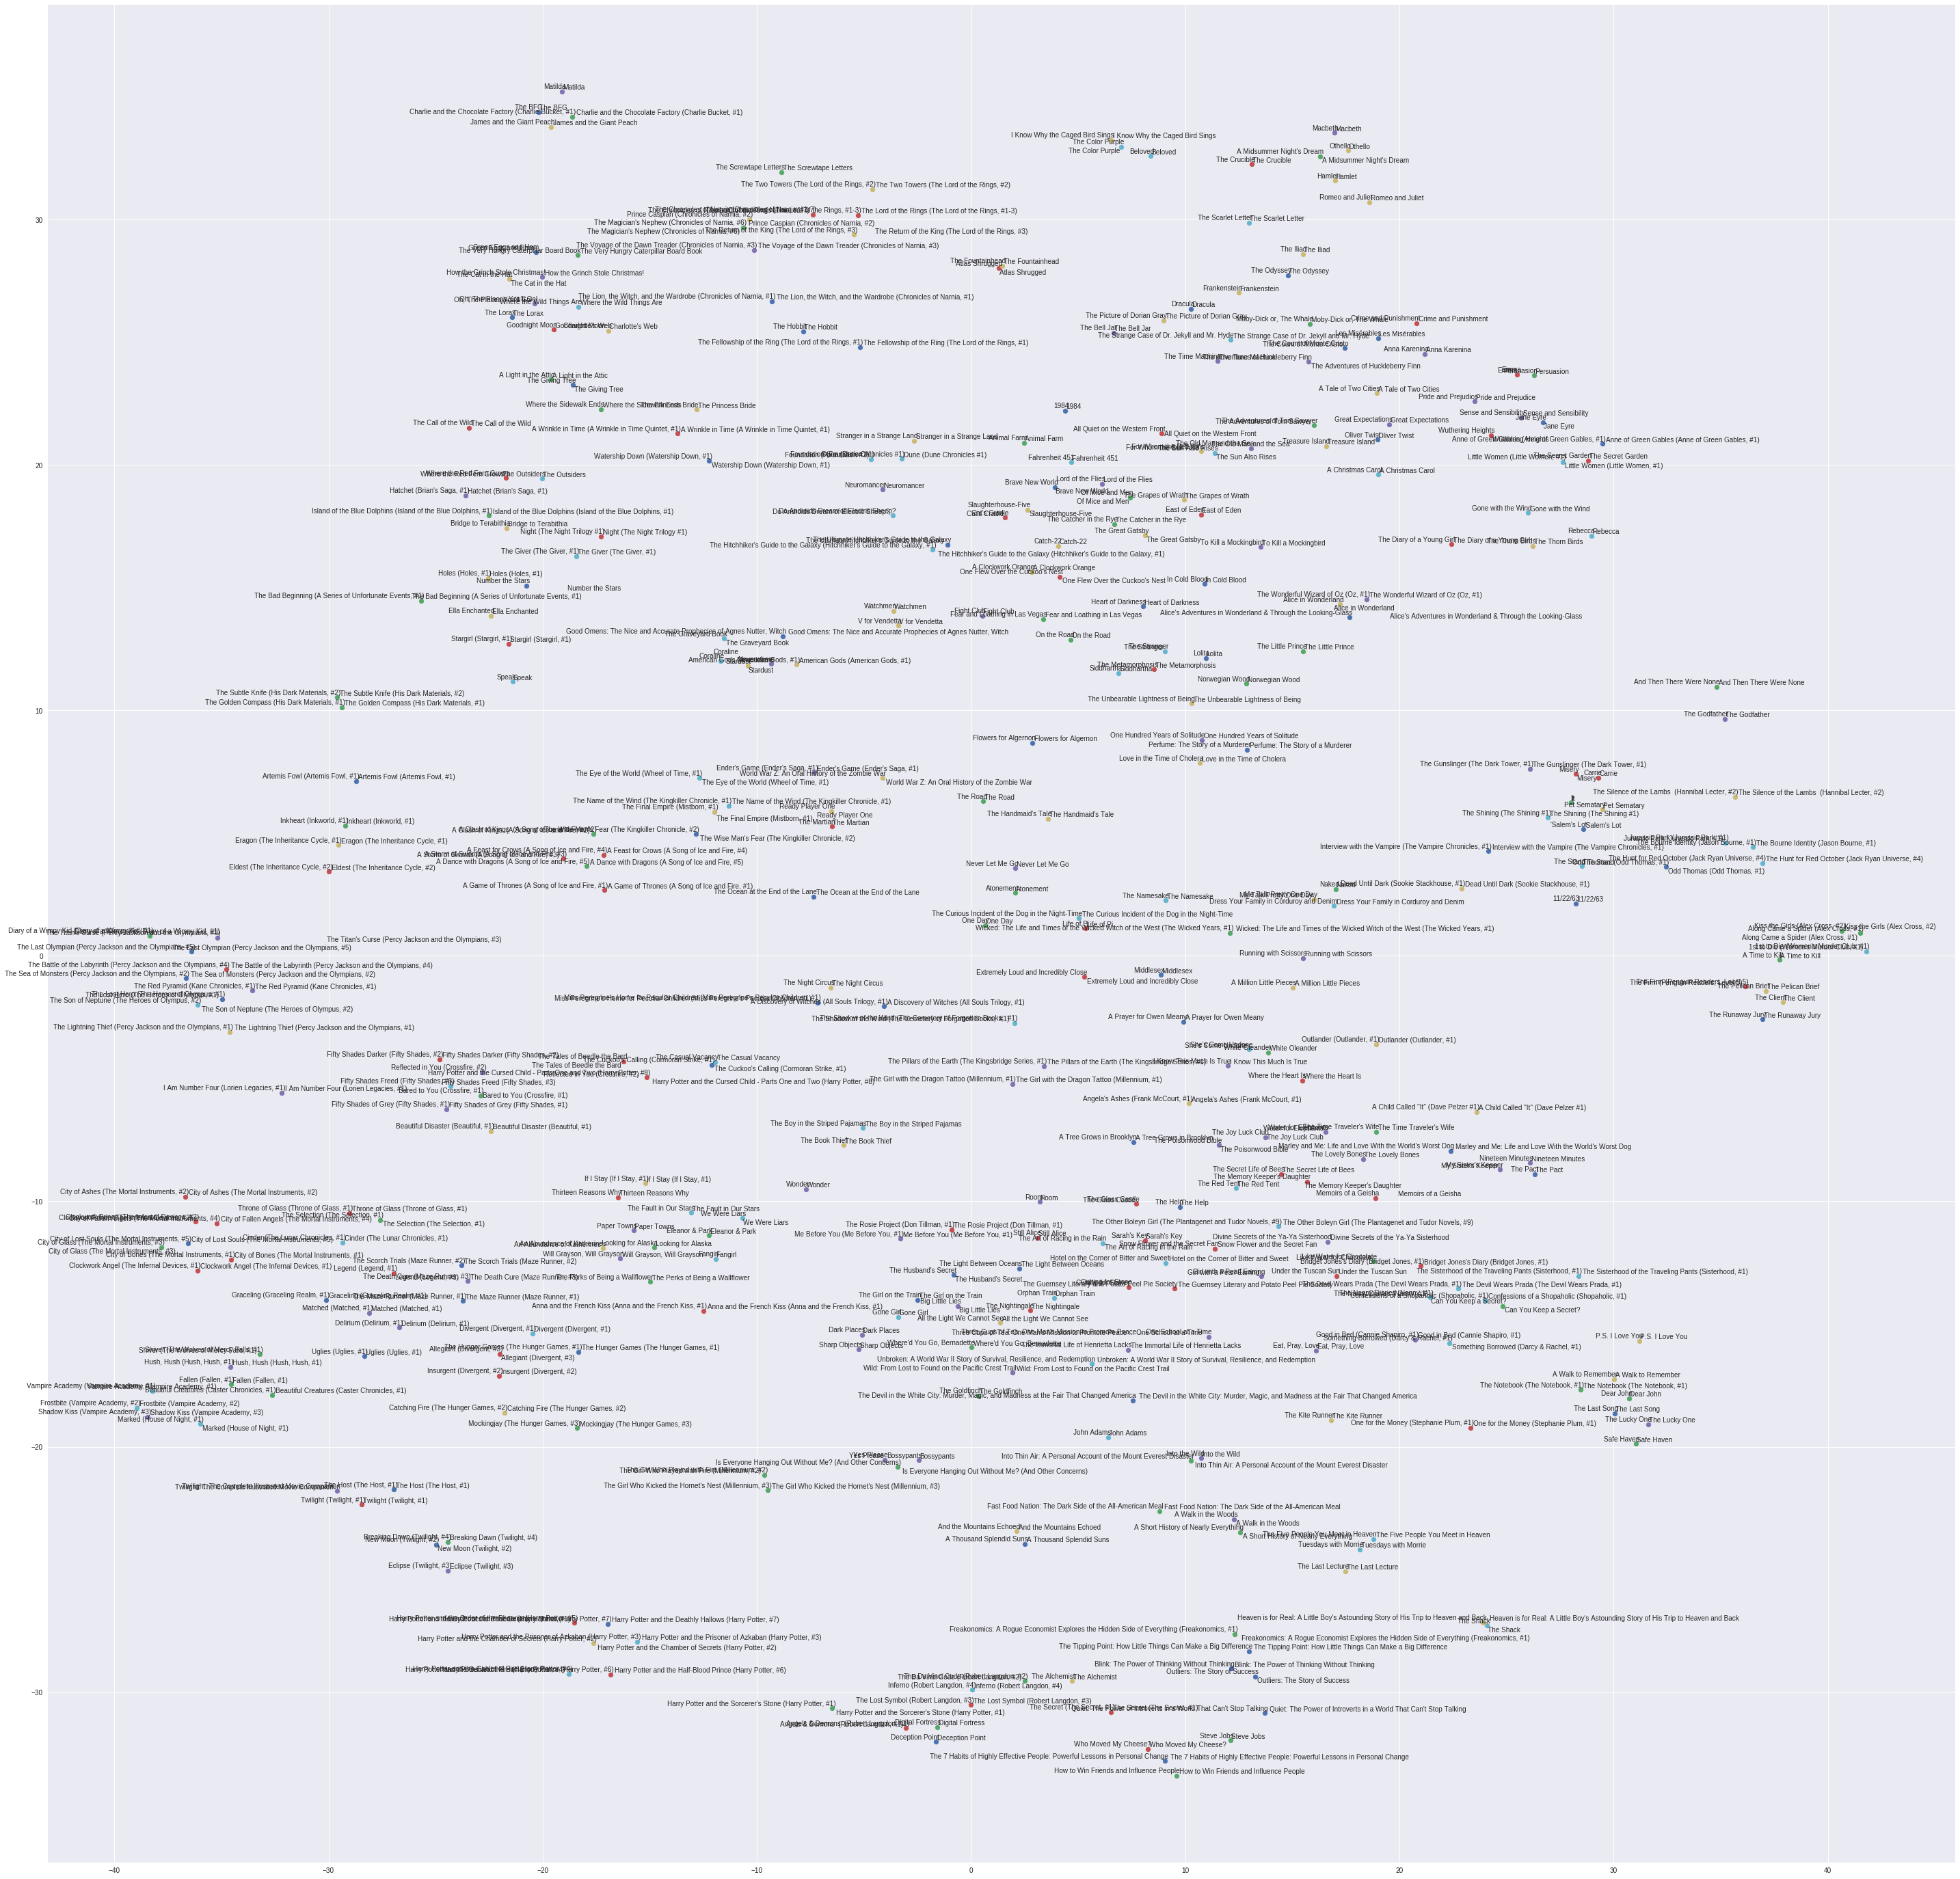

['datalab', 'foo.png', 'job.png', '.forever', '.keras', 'foo7.png', '.local', 'MODEL', 'foo5.png', 'model.zip', 'foo.jpg', '.cache', '.config', '.ipython', 'foo4.png', 'foo3.png', 'foo2.png', 'books.csv']


In [0]:
#Plot book embeddings 

texts = []

def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pyplot.figure(figsize=(30, 30))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pyplot.scatter(x, y)
    pyplot.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
    texts.append(pyplot.text(x, y, label))
  adjust_text(texts)
  pyplot.show()

plot(two_d_embeddings, books)


In [0]:
#Plot book softmax embeddings 

texts = []

def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pyplot.figure(figsize=(30, 30))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pyplot.scatter(x, y)
    pyplot.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
    texts.append(pyplot.text(x, y, label))
  adjust_text(texts)
  pyplot.show()

plot(two_d_embeddingsSM, books)
